# SIM-SOENS
This is a walkthrough of basic SIM-SOENs functionality, along with supporting input, readout, and analitic tools--all in a common syntax defined specifically for working with Simulated Superconducting Optoelectronic Networks (Sim-SOENs).

- Start with importing necesary libraries, modules, and Sim-SOEN-sepcific assets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from _util import physical_constants, set_plot_params, index_finder
from _util__soen import dend_load_rate_array, dend_load_arrays_thresholds_saturations
from soen_sim import input_signal, synapse, neuron, network
from soen_sim_lib__common_components__simple_gates import common_dendrite, common_synapse, common_neuron

from _plotting__soen import raster_plot
from super_net import SuperNet
from super_input import SuperInput
from zoo import CustomNeurons
from params import default_neuron_params




Complete!


## Input
Before delving into neuron and network dynamics, let's first get familiar with input defitions.
- Significant felxibility is available for generating spiking input that is natively understood by Sim-SOENs.
- A few key parameters should be passed into the `Input` class.
- A number of hidden parameters may also be definted and are otherwise set to default values.
- The code below generates a single input channel of random spiking events for a duration of 100ns.

Generating random input...


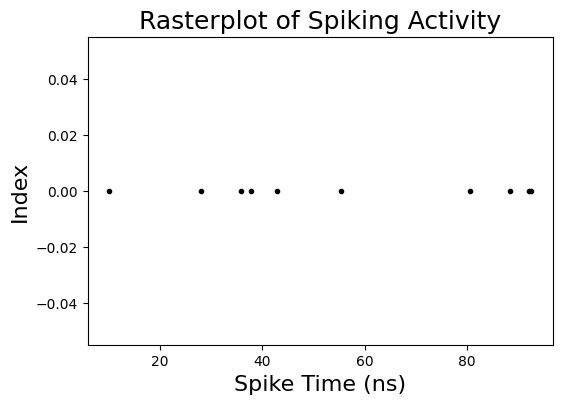

In [2]:
input_single = SuperInput(channels=1, type='random', total_spikes=10, duration=100)
raster_plot(input_single.spike_arrays,notebook=True)

Generating random input...


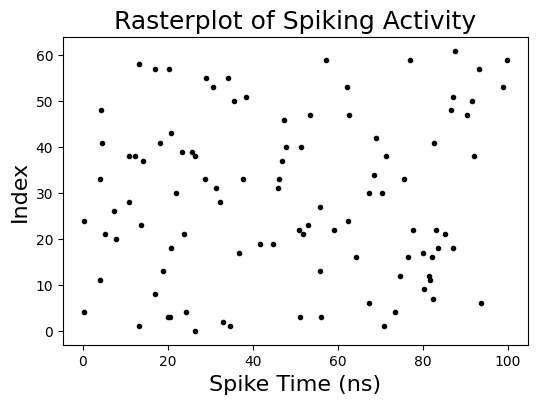

In [3]:
# More channels, more spikes
input_multi = SuperInput(channels=64, type='random', total_spikes=100, duration=100)
raster_plot(input_multi.spike_arrays,notebook=True)

### Spiking MNIST Dataset
The classic MNIST handwritten digit dataset can be generated by assigning each of the 28x28 pixels an input channel index, and generating Poisson spiking-even distributions with rates according to the pixel intensity at that pixel
- Note that the `slow_down` argument corresponds to the factor by which rates are slowed down (SOENs like data to have a frequency less that 1 spike per 35 ns)
- *Fix indexing and add all digits

Generating MNNIST dataset...
load
loaded


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


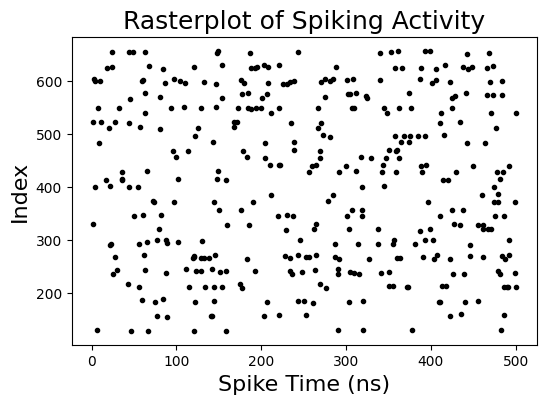

In [4]:
# *change to load previously generated patterns
input_MNIST = SuperInput(type='MNIST', index=0, slow_down=10, duration=500)
raster_plot(input_MNIST.spike_arrays,notebook=True)

## The Neuron
SOEN neurons have special structure that corresponds to their physical design parameters.
- At least one SPD synaspse
- At least one SQUID-dendrite
- One SQUID soma
- One refractory SQUID-dendrite
- *A SQUID a superconducting quantum interference device, but computationally can be though of as a simple signal integrator with a leak

To call a simple single-synapse, single-dendrite neuron, use:

### The Synapse
- A *single photon detector* responds to incoming light signals with a simple eponential rise and decay function
 - Photon trikes SPD
 - SPD enters resistive state
 - Provokes flux from SPD to Dendritic Receiver Loop according to 
$$\phi_r = \phi_{peak}(1-\frac{\tau_{rise}}{\tau_{fall}})\times   \left\{
\begin{array}{ll}
      [1-e^{-t/\tau_{rise}}] & 0 \leq t \leq t_0 \\
      [1-e^{-t_0/\tau_{rise}}]e^{-(t-t_0)/\tau_{fall}} &  t > t_0 \\
\end{array} 
\right.  $$ 
- $\phi_{peak} = 0.5$
- $t_0 \approx 200ps$
- $\tau_{rise}$ on order of ps
- $\tau_{fall}$ on order of ns

Generating pre-defined input...

running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 9.10008e-02s



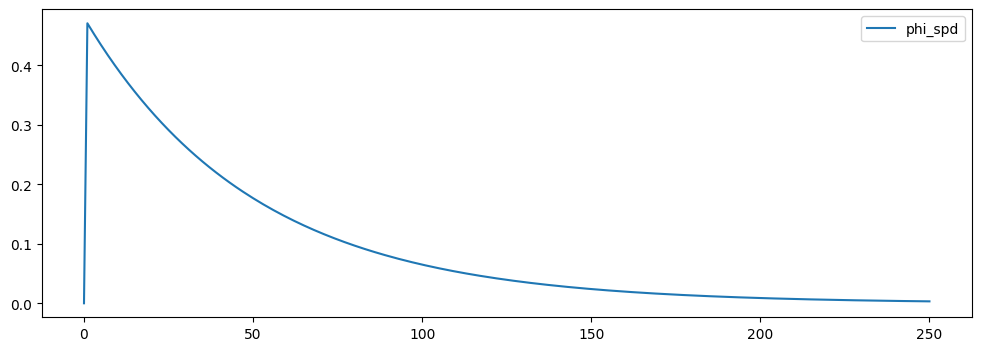

In [2]:
# define photon incidence on first (only synapse) at 5 ns and generate input
def_spikes = [[0],[.5]]
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=50)

# define a single neuron with default neuron parameters
sing = CustomNeurons(type='single',**default_neuron_params)
sing.synapse.add_input(input_.signals[0])

# create single-neuron netowork, add the neuron, and run
net = network(name = 'network_under_test')
net.add_neuron(sing.neuron)
net.run_sim(dt = .1, tf = 250)
net.get_recordings()

# pull SPD response from synapse through dendrite
spd = sing.dendrite.synaptic_inputs[1].phi_spd

# plot (skip 10 for dt of .1)
plt.figure(figsize=(12,4))
plt.plot(spd[::10], label='phi_spd')
plt.legend()

## The Dendrite
- The signal $s$ accumulated in the dendrite is defined by
$$\beta \frac{ds}{d\tau}=r(\phi,s;i_b)-\alpha s$$
- $\alpha$ and $\beta$ are physical constants that contribute signal decay over time
- $\phi$ is incoming flux (from SPD through dendritic receiving loop)
- $\tau$ the time constant of signal decay
- $i_b$ is the the bias current which will determine proximity to firing threshold
- $r(...)$  is a rate array function which has been numerically solved
  - The code backend pulls from saved solutions to rate arrays

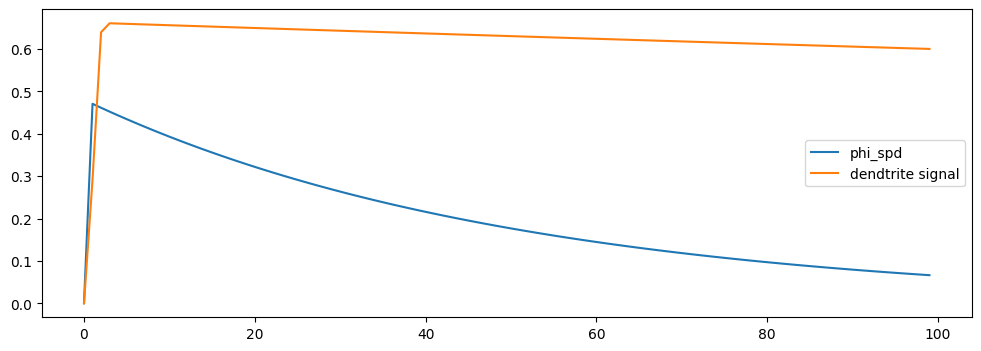

In [3]:
dend_s = sing.dendrite.s

plt.figure(figsize=(12,4))
plt.plot(spd[::10][:100], label='phi_spd')
plt.plot(dend_s[::10][:100], label='dendtrite signal')
plt.legend()


### Customizing parameters
- Default_neuron_parameters is simply a dictionary
- Any value for any key can of course be changed
- Print to see options
  - `_di` -> dendritic parameter
  - `_ni`  -> neuron (soma) parameters
  - `_ref` -> refractory parameters
  - `w_..` refers to connection strength between these elements (dn -> dendrite to neuron) 

In [4]:
for k,v in default_neuron_params.items():
    print(k," = ", v)

beta_di  =  628.3185307179587
tau_di  =  1000
ib  =  1.802395858835221
ib_n  =  1.802395858835221
s_th_factor_n  =  0.1
beta_ni  =  6283.185307179586
tau_ni  =  50
w_sd  =  1
w_sid  =  1
w_dd  =  0.5
w_dn  =  0.5
ib_ref  =  1.7523958588352209
beta_ref  =  62831.853071795864
tau_ref  =  500
s_max_n  =  0.7553237900539593


c:\Users\rmo2\Desktop\sim_soens\soen_sim.py:215: RuntimeWarning: divide by zero encountered in double_scalars
  rdi = Ldi/tau_di



running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 8.20302e-02s



c:\Users\rmo2\Desktop\sim_soens\_functions__soen.py:318: RuntimeWarning: invalid value encountered in double_scalars
  dendrite_object.s[time_index+1] = dendrite_object.s[time_index] * ( 1 - d_tau*dendrite_object.alpha/dendrite_object.beta) + (d_tau/dendrite_object.beta) * r_fq



running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 8.91759e-02s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 9.20689e-02s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 1.04035e-01s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 9.20660e-02s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 9.10090e-02s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 8.99995e-02s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 8.81607e-02s


running network time stepper for 2.50e+02ns (2501 time steps) ...
done running network time stepper. t_sim = 8.94595e-02s


running

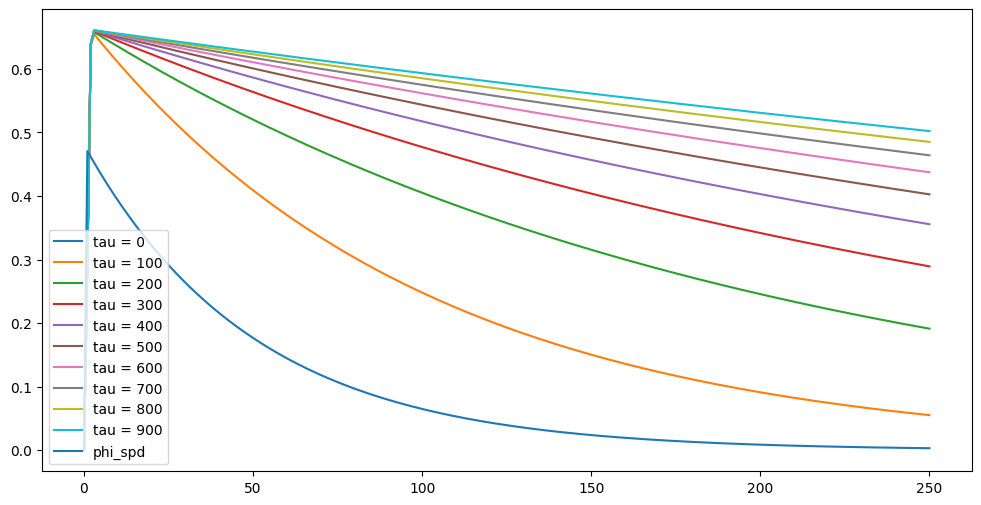

In [5]:
dendritic_signals = []
taus = np.arange(0,1000,100)

plt.figure(figsize=(12,6))
for tau in taus:

    # default parameters can always be adjusted before call
    default_neuron_params['tau_di'] = tau

    # this neuron now has a dendrite with a new time constant
    sing = CustomNeurons(type='single',**default_neuron_params)
    sing.synapse.add_input(input_.signals[0])

    net = network(name = 'network_under_test')
    net.add_neuron(sing.neuron)
    net.run_sim(dt = .1, tf = 250)
    net.get_recordings()
    dend_s = sing.dendrite.s
    dendritic_signals.append(dend_s)
    plt.plot(dend_s[::10], label=f'tau = {tau}')

plt.plot(spd[::10], label='phi_spd')
plt.legend()


## The Soma
- Signal from any upstream dendrites is coupled to and interated by the soma
- When threshold is reached, soma: 
  - Depletes its stored signal
  - Invokes HTRON to activate silicon diode lightsource
  - Sends photons to all downstream neurons
  - Couple flux to refractory dendrite which recursively inhibits somatic signal
    - Refractory dendrite has its own adjustable dendritic parameters

Generating pre-defined input...

running network time stepper for 1.00e+02ns (1001 time steps) ...
done running network time stepper. t_sim = 4.39975e-02s



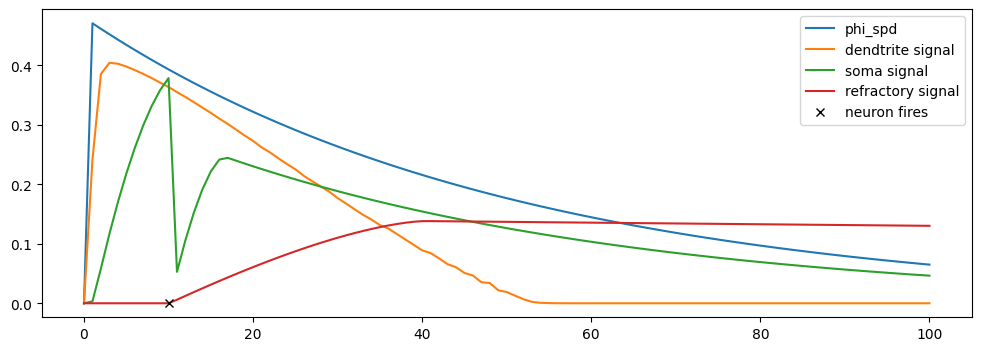

In [14]:
default_neuron_params["s_th_factor_n"] = 0.5
default_neuron_params['w_dn'] = 1
default_neuron_params['tau_di'] = 1
default_neuron_params['tau_ref'] = 1000
def_spikes = [[0],[.5]]
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=100)

sing = CustomNeurons(type='single',**default_neuron_params)
sing.synapse.add_input(input_.signals[0])

net = network(name = 'network_under_test')
net.add_neuron(sing.neuron)
net.run_sim(dt = .1, tf = 100)
net.get_recordings()

spd = sing.dendrite.synaptic_inputs[1].phi_spd
dend_s = sing.dendrite.s
signal = net.neurons[1].dend__nr_ni.s
ref = net.neurons[1].dend__ref.s

plt.figure(figsize=(12,4))
plt.plot(spd[::10], label='phi_spd')
plt.plot(dend_s[::10], label='dendtrite signal')
plt.plot(signal[::10], label='soma signal')
plt.plot(ref[::10], label='refractory signal')
plt.plot(net.spikes[1]*1000,net.spikes[0],'xk', label='neuron fires')
plt.legend()


Generating pre-defined input...

running network time stepper for 5.00e+02ns (5001 time steps) ...
done running network time stepper. t_sim = 1.85999e-01s



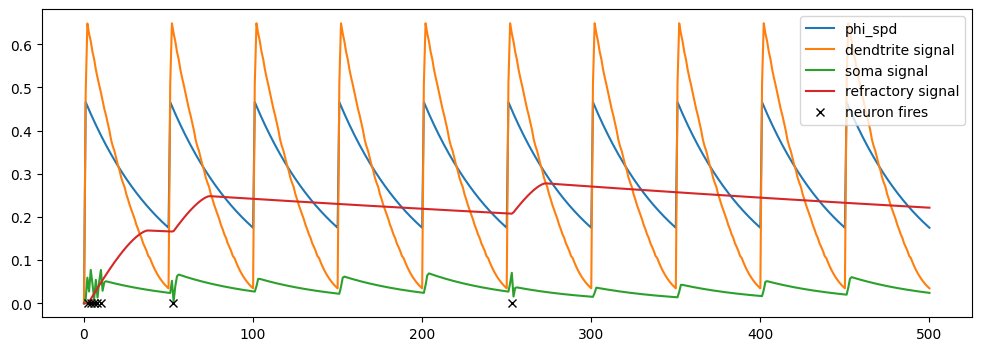

In [18]:
# define spike times
times = np.arange(0,500,50)
indices = np.zeros(len(times)).astype(int)
def_spikes = [indices,times]

# generate input
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=500)

# customize neuron parameters
default_neuron_params['w_dn'] = 0.5
default_neuron_params['tau_di'] = 10
default_neuron_params['tau_ref'] = 1000
default_neuron_params["s_th_factor_n"] = 0.1


neo = CustomNeurons(type='single',**default_neuron_params)
neo.synapse.add_input(input_.signals[0])


net = network(name = 'network_under_test')
net.add_neuron(neo.neuron)
net.run_sim(dt = .1, tf = 500)
net.get_recordings()

spd = neo.dendrite.synaptic_inputs[1].phi_spd
dend_s = neo.dendrite.s
signal = net.neurons[1].dend__nr_ni.s
ref = net.neurons[1].dend__ref.s

plt.figure(figsize=(12,4))
plt.plot(spd[::10], label='phi_spd')
plt.plot(dend_s[::10], label='dendtrite signal')
plt.plot(signal[::10], label='soma signal')
plt.plot(ref[::10], label='refractory signal')
plt.plot(net.spikes[1]*1000,net.spikes[0],'xk', label='neuron fires')
plt.legend()

## Dendritic Arbor
- A single synapse (currently) can only take input from $\approx1-10$ upstream sources
  - Comes with higher synaptic requirements to induce somatic firing
- To accomodate more sizeable fan-in, dendritic arbors may be constructed

In [19]:
# custom parameters
default_neuron_params['w_dn'] = 0.9
default_neuron_params['w_dd'] = 0.9
default_neuron_params['tau_di'] = 10
default_neuron_params['tau_ref'] = 1000
default_neuron_params["s_th_factor_n"] = 0.5

# single 3-fractal neurons (9 synapses feed into 9 dendrites, feed into 3 dendrites, feed into 1 soma)
neo = CustomNeurons(type='3fractal',**default_neuron_params)

layer: 0
  dendrite 0
  dendrite 1
  dendrite 2
layer: 1
  dendrite 0
  dendrite 1
  dendrite 2
  dendrite 3
  dendrite 4
  dendrite 5
  dendrite 6
  dendrite 7
  dendrite 8


Generating random input...


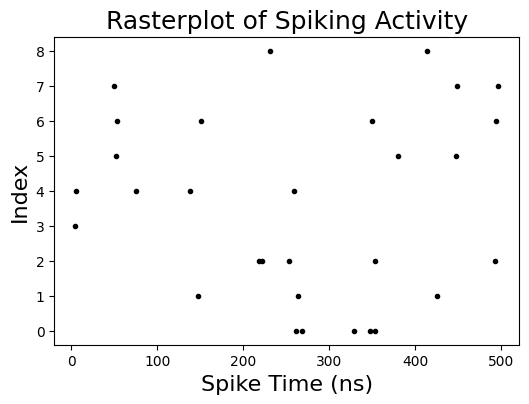

In [20]:
# generate and plot 8 dimensional random inpot
input = SuperInput(channels=9, type='random', total_spikes=30, duration=500)
raster_plot(input.spike_arrays,notebook=True)



running network time stepper for 5.00e+02ns (5001 time steps) ...
done running network time stepper. t_sim = 8.48665e-01s



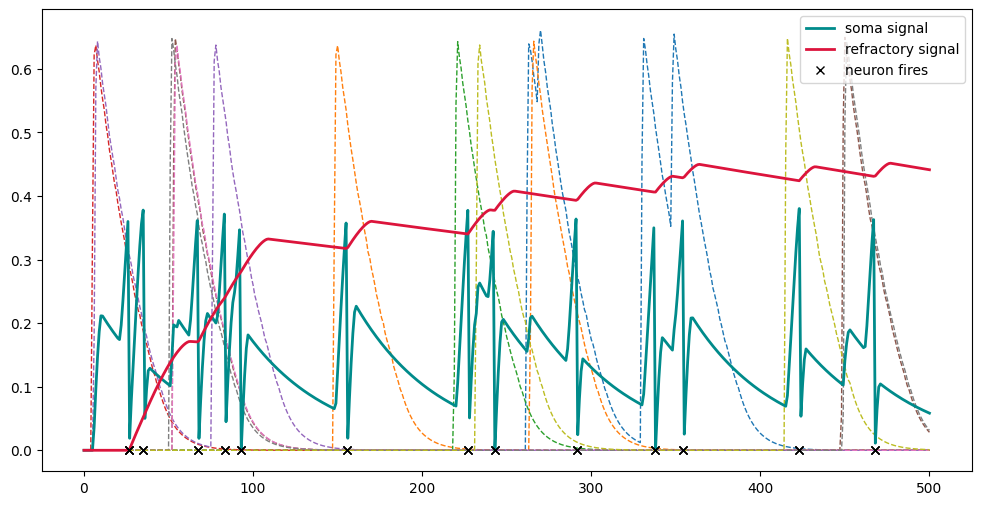

In [24]:
# Attach one input channel per synapse
for i in range(len(neo.synapses)):
    neo.synapses[i].add_input(input.signals[i])

# create and run network
net = network(name = 'network_under_test')
net.add_neuron(neo.fractal_neuron)
# net.neurons['name'].name = 1 # sometimes naming bug
net.run_sim(dt = .1, tf = 500)
net.get_recordings()

# tau_convert = 1/net.neurons[1].time_params['t_tau_conversion'] 
signal = net.neurons[1].dend__nr_ni.s
ref = net.neurons[1].dend__ref.s

plt.figure(figsize=(12,6))
for i in range(9):
    spd = neo.dendrites[1][i].synaptic_inputs[i].phi_spd
    dend_s = neo.dendrites[1][i].s
    # plt.plot(spd,'--') #, label='phi_spd_'+str(i))
    plt.plot(dend_s[::10],'--', linewidth=1) #, label='dendtrite signal '+str(i))
plt.plot(signal[::10], linewidth=2, color='darkcyan', label='soma signal')
plt.plot(ref[::10], linewidth=2, color='crimson', label='refractory signal')
plt.plot(net.spikes[1]*1000,net.spikes[0],'xk', label='neuron fires')
plt.legend()

## Networking

In [25]:
input_MNIST = SuperInput(type='MNIST', index=0, slow_down=100, duration=500)

Generating MNNIST dataset...
load
loaded


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [26]:
# custom parameters
default_neuron_params['w_dn'] = 0.9
default_neuron_params['w_dd'] = 1
default_neuron_params['tau_di'] = 1
default_neuron_params['tau_ref'] = 1
default_neuron_params["s_th_factor_n"] = 0.1

neural_net = SuperNet(N=100,duration=500,in_connect="ordered") #dendrites,synapses
neural_net.connect_input(input_MNIST)
neural_net.run(dt=1)
neural_net.record(['spikes'])

input neurons:  38

running network time stepper for 5.02e+02ns (503 time steps) ...
done running network time stepper. t_sim = 8.96342e+00s

spikes


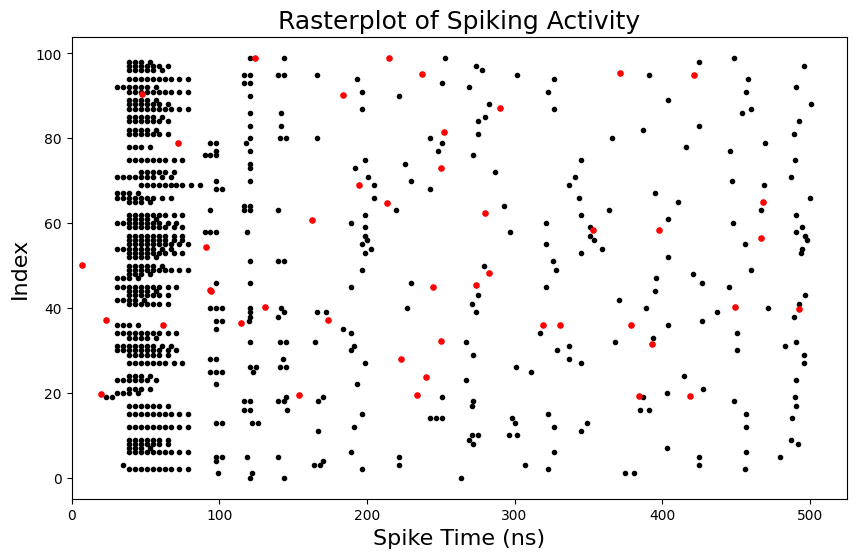

In [28]:
spikes = neural_net.spikes
spikes = [spikes[0],spikes[1]*1000]
raster_plot(spikes,duration=500,input=input_MNIST.spike_arrays)